# Case Study: Predicting Umbrella Insurance

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')  # I prefer the appearance of the "old-school" color scheme
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

%matplotlib inline
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, accuracy_score, r2_score, roc_curve, precision_recall_curve
import xgboost as xgb
import seaborn as sns


pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)
np.set_printoptions(edgeitems=30, linewidth=100000)


In [22]:
import modeling_utils as mu

## Load data

Download the file and place in the same directory as the notebook.

In [14]:
df_ins = pd.read_csv('ins_data_ODSC_West_2019.csv')
df_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10670 entries, 0 to 10669
Data columns (total 20 columns):
Unnamed: 0                   10670 non-null int64
has_umbrella                 10670 non-null int64
homeown_premium              10670 non-null float64
auto_premium                 10670 non-null float64
num_home_pol                 10670 non-null float64
home_dwell_cov               8781 non-null float64
home_pers_prop_cov           10015 non-null float64
num_vehicles                 10514 non-null float64
max_vehicle_year             10514 non-null float64
min_vehicle_year             10514 non-null float64
num_drivers_by_dob           10670 non-null float64
yob_policyholder             8706 non-null float64
max_driver_yob               9334 non-null float64
min_driver_yob               9334 non-null float64
state_abbrev                 10632 non-null object
avg_homeown_rate_in_state    10632 non-null float64
median_household_income      10518 non-null float64
median_house_val

## Data Exploration
This data set contains information about different insurance customers who have both home insurance and auto insurance with an agency.  The information includes their premiums, coverages, vehicles, drivers, state of residence, and zip-code demographics.


In this exercise we will be building a model to predict who is likely to have an umbrella policy.  Imagine, that our goal is to be able to recommend to new agencies (which currently don't sell umbrella policies) which customers are the best candidates.  Our binary outcome variable is `has_umbrella` 



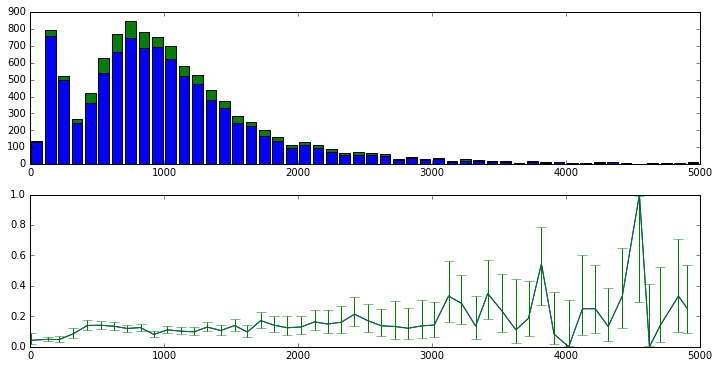

In [15]:
mu.histogram_pair(df_ins.homeown_premium, df_ins.has_umbrella, bins=np.linspace(0,5000, 51));

In [16]:
my_bins = np.concatenate((np.linspace(0,2000,21),np.linspace(2500,5000,6)))
my_bins

array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2500., 3000., 3500., 4000., 4500., 5000.])

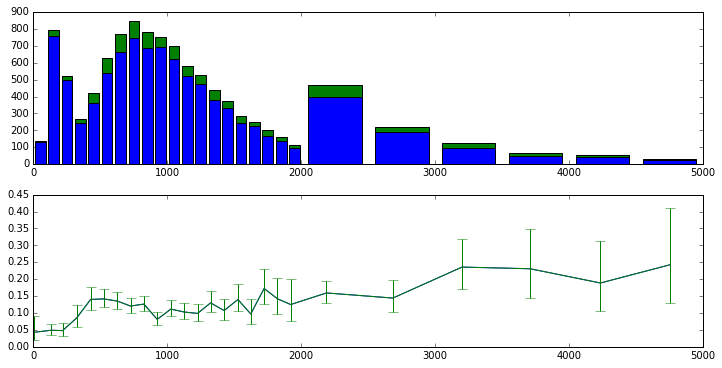

In [17]:
mu.histogram_pair(df_ins.homeown_premium, df_ins.has_umbrella, bins=my_bins);

In [18]:
X_full = df_ins.drop(['has_umbrella'], axis=1)
y = df_ins.has_umbrella

In [23]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=.3, random_state=42)

In [24]:
baseline_ins = ['auto_premium','homeown_premium', 'num_vehicles']
X_train_bl = X_train_full.loc[:,baseline_ins].copy()
X_test_bl = X_test_full.loc[:,baseline_ins].copy()

In [34]:
X_train_bl['auto_premium'] = X_train_bl.auto_premium.fillna(X_train_bl['auto_premium'].median())
X_train_bl['homeown_premium'] = X_train_bl.homeown_premium.fillna(X_train_bl['homeown_premium'].median())
X_train_bl['num_vehicles'] = X_train_bl.num_vehicles.fillna(X_train_bl['num_vehicles'].median())

X_test_bl['auto_premium'] = X_test_bl.auto_premium.fillna(X_train_bl['auto_premium'].median())
X_test_bl['homeown_premium'] = X_test_bl.homeown_premium.fillna(X_train_bl['homeown_premium'].median())
X_test_bl['num_vehicles'] = X_test_bl.num_vehicles.fillna(X_train_bl['num_vehicles'].median())

/opt/local/istRsapp/Anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/local/istRsapp/Anaconda/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


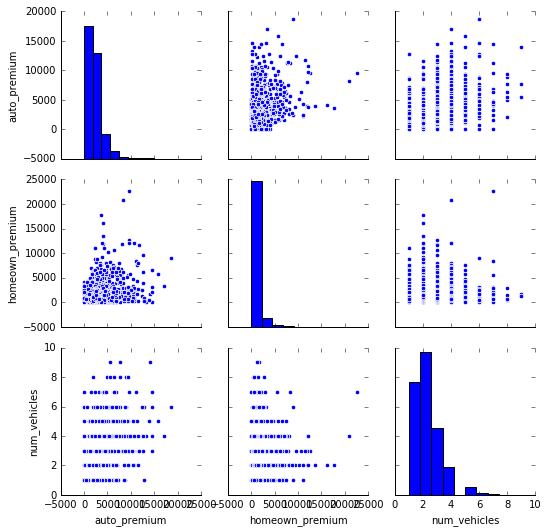

In [29]:
sns.pairplot(X_train_bl)

In [35]:
lr_baseline = LogisticRegression(solver='lbfgs')
lr_baseline.fit(X_train_bl, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
pred_probs_lr_bl = lr_baseline.predict_proba(X_test_bl)[:,1]

In [37]:
roc_auc_score(y_test, pred_probs_lr_bl), log_loss(y_test, pred_probs_lr_bl)

(0.5833312200070228, 0.3501312198506307)

In [38]:
boost_ins=['auto_premium','homeown_premium', 'num_vehicles', 'median_household_income', 'median_house_value','yob_policyholder']

In [39]:
X_train_bt = X_train_full.loc[:,boost_ins].copy()
X_test_bt = X_test_full.loc[:,boost_ins].copy()